# 사전 준비 

In [8]:
!unzip /content/drive/MyDrive/DataSet/작물병해/data.zip

Archive:  /content/drive/MyDrive/DataSet/작물병해/data.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [9]:
!unzip train.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   creating: train/55844/
  inflating: train/55844/55844.jpg   
  inflating: train/55844/55844.json  
  inflating: train/55844/55844.csv   
   creating: train/55847/
  inflating: train/55847/55847.jpg   
  inflating: train/55847/55847.csv   
  inflating: train/55847/55847.json  
   creating: train/55848/
  inflating: train/55848/55848.json  
  inflating: train/55848/55848.csv   
  inflating: train/55848/55848.jpg   
   creating: train/55858/
  inflating: train/55858/55858.json  
  inflating: train/55858/55858.jpg   
  inflating: train/55858/55858.csv   
   creating: train/55870/
  inflating: train/55870/55870.json  
  inflating: train/55870/55870.csv   
  inflating: train/55870/55870.jpg   
   creating: train/55889/
  inflating: train/55889/55889.jpg   
  inflating: train/55889/55889.csv   
  inflating: train/55889/55889.json  
   creating: train/55895/
  inflating: train/55895/55895.jpg   
  inflating: train/55895/55895.csv   
  inflating: train/558

# 모듈 임포트

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import cv2 
from glob import glob
from tqdm import tqdm
import json

In [18]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import resnet50, efficientnet,vgg16
from tensorflow.keras.applications import ResNet50, EfficientNetB0,VGG16
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

# 데이터 로드 

## 디렉토리 로드 

In [3]:
train_csv = sorted(glob('train/*/*.csv'))
train_jpg = sorted(glob('train/*/*.jpg'))
train_json = sorted(glob('train/*/*.json'))

## 리사이즈 이후 

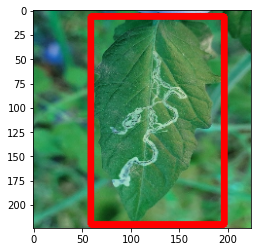

In [45]:
# #이미지 로드 
# i = 35
# img_path = train_jpg[i]
# img = cv2.imread(img_path)
# img_shape = img.shape

# #bbox 로드 
# json_path = train_json[i]
# with open(json_path, 'r') as f:
#   sample = json.load(f)
# point = sample['annotations']['bbox'][0]

# #리사이즈 
# img = cv2.resize(img, dsize=  (224,224))
# point['x'] = point['x'] * (224/img_shape[1])
# point['w'] = point['w'] * (224/img_shape[1])
# point['y'] = point['y'] * (224/img_shape[0])
# point['h'] = point['h'] * (224/img_shape[0])
# img = cv2.rectangle(
#     img,
#     (int(point['x']), int(point['y'])),
#     (int((point['x']+point['w'])), int((point['y']+point['h']))),
#     (255, 0, 0),
#     5
# )

# plt.imshow(img)

## 이미지 - json 동시 로드 

In [6]:
imgs = []
labels = []
bboxes = [] 
for i in tqdm(range(len(train_csv))):
  #디렉토리 설정 
  img_path = train_jpg[i]
  json_path = train_json[i]

  #이미지 로드 
  img = cv2.imread(img_path)
  img_shape = img.shape 

  #json 로드 
  with open(json_path, 'r') as f:
    sample = json.load(f)
  crop = sample['annotations']['crop']
  disease = sample['annotations']['disease']
  risk = sample['annotations']['risk']
  label=f"{crop}_{disease}_{risk}"

  point = sample['annotations']['bbox'][0]

  #리사이즈 
  img = cv2.resize(img, dsize=  (224,224))
  point['x'] = point['x'] * (224/img_shape[1])
  point['w'] = point['w'] * (224/img_shape[1])
  point['y'] = point['y'] * (224/img_shape[0])
  point['h'] = point['h'] * (224/img_shape[0])
  bbox = list(point.values())

  #append
  labels.append(label)
  bboxes.append(bbox) #x,h,y,w 순서 
  imgs.append(img)

label_unique = sorted(np.unique(labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}
label_decoding = {value:key for key,value in zip(label_unique, range(len(label_unique)))}

labels = [label_unique[k] for k in labels]

imgs = np.array(imgs)
bboxes = np.array(bboxes)
labels = np.array(labels)

100%|██████████| 5767/5767 [00:30<00:00, 186.35it/s]


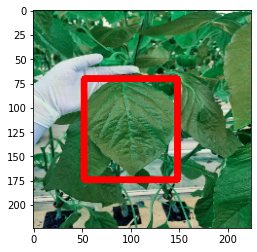

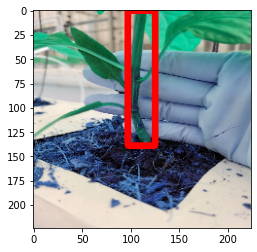

In [5]:
# # 확인 
# for i in range(2):
#   img = imgs[i]
#   point = bboxes[i]
#   temp_img = cv2.rectangle(
#       img,
#       (int(point[0]), int(point[2])),
#       (int((point[0]+point[3])), int((point[2]+point[1]))),
#       (255, 0, 0),
#       5
#   )

#   plt.imshow(temp_img)
#   plt.show()

## CSv 로드 

In [7]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
               '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

In [8]:
def csv_load(path):
    temp = pd.read_csv(path)
    temp = np.array(temp[csv_features])
    try:
      temp = temp.astype(float)
    except:
      temp[temp=='-']=0.
      temp = temp.astype(float)
    temp = cv2.resize(temp, dsize = (9,144))
    return temp

csvs = [csv_load(k) for k in tqdm(train_csv)]
csvs = np.array(csvs)

100%|██████████| 5767/5767 [00:41<00:00, 140.27it/s]


# 전처리

## augmentation

In [9]:
#사용자 정의 함수 
def rotate_img_bbox(image,point,degree):
  if degree == 90:
    img90 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    x_90 = point[2] # y 값 
    y_90 = 224-point[0] # 224 - x값 
    w = point[1]
    h = -point[3]
    return img90, [x_90,h,y_90,w]
  if degree == 180:
    img180 = cv2.rotate(image, cv2.ROTATE_180)
    x_180 =  224 - point[0] - point[3]
    y_180 = 224-point[1] - point[2]
    w = point[3]
    h = point[1]
    return img180, [x_180,h,y_180,w]
  if degree == 270: 
    img270 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    x_270 = 224-point[1]-point[2]
    y_270 = point[0]
    w = point[1]
    h = point[3]
    return img270, [x_270,h,y_270,w]

In [10]:
#img 90 
img_90 = [] 
bbox_90 = []
for index in range(len(imgs)):
  img = imgs[index]
  bbox = bboxes[index]

  temp_img ,temp_bbox = rotate_img_bbox(img,bbox,90)
  img_90.append(temp_img)
  bbox_90.append(temp_bbox)

img_90 = np.array(img_90)
bbox_90 = np.array(bbox_90)

#img 180 
img_180 = [] 
bbox_180 = []
for index in range(len(imgs)):
  img = imgs[index]
  bbox = bboxes[index]

  temp_img ,temp_bbox = rotate_img_bbox(img,bbox,180)
  img_180.append(temp_img)
  bbox_180.append(temp_bbox)

img_180 = np.array(img_180)
bbox_180 = np.array(bbox_180)

#img 270 
img_270 = [] 
bbox_270 = []
for index in range(len(imgs)):
  img = imgs[index]
  bbox = bboxes[index]

  temp_img ,temp_bbox = rotate_img_bbox(img,bbox,270)
  img_270.append(temp_img)
  bbox_270.append(temp_bbox)

img_270 = np.array(img_270)
bbox_270 = np.array(bbox_270)

In [140]:
print(img_90.shape,img_180.shape,img_270.shape)

(5767, 224, 224, 3) (5767, 224, 224, 3) (5767, 224, 224, 3)


In [20]:
augmented_imgs = np.concatenate([imgs,img_90,img_180,img_270])
augmented_bboxes = np.concatenate([bboxes,bbox_90,bbox_180,bbox_270])
augmented_labels = np.concatenate([labels,labels,labels,labels])
augmented_csvs = np.concatenate([csvs,csvs,csvs,csvs])

In [151]:
print(augmented_imgs.shape,augmented_bboxes.shape,augmented_labels.shape,augmented_csvs.shape)

(23068, 224, 224, 3) (23068, 4) (23068,) (23068, 144, 9)


## 믹싱 

In [21]:
index = np.arange(len(augmented_imgs))
np.random.shuffle(index)

In [22]:
augmented_labels = augmented_labels[index]
augmented_bboxes= augmented_bboxes[index]
augmented_csvs = augmented_csvs[index]
augmented_imgs = augmented_imgs[index]

In [ ]:
augmented_imgs = vgg16.preprocess_input(augmented_imgs)

## 트레인 - 테스트 분할

In [15]:
index = int(len(augmented_csvs)*0.9)
train_imgs = augmented_imgs[:index]
test_imgs = augmented_imgs[index:]

train_csvs = augmented_csvs[:index]
test_csvs = augmented_csvs[index:]

train_labels = augmented_labels[:index]
test_labels = augmented_labels[index:]

train_bboxes = augmented_bboxes[:index]
test_bboxes = augmented_bboxes[index:]

In [157]:
print(train_imgs.shape, train_csvs.shape, train_labels.shape,train_bboxes.shape)

(20761, 224, 224, 3) (20761, 144, 9) (20761,) (20761, 4)


# 모델링 

## 사전 설정 

In [16]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=50)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=25,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

In [17]:
#optimizer leraning rate 조절 
adam = optimizers.Adam(learning_rate = 0.0005)

In [19]:
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [161]:
#어그먼테이션
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomTranslation([-0.1, 0.1], [-0.1, 0.1], seed = 777),
    tf.keras.layers.experimental.preprocessing.RandomCrop(224, 224, seed = 777),
    tf.keras.layers.experimental.preprocessing.RandomZoom([-0.1, 0.1], [-0.1, 0.1], seed = 777),
    tf.keras.layers.experimental.preprocessing.RandomRotation([-0.1, 0.1], seed = 777),
    tf.keras.layers.experimental.preprocessing.CenterCrop(224, 224),
])

## Phase 1 - bbox extraction 

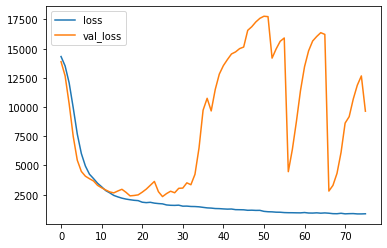

loss =  864.521728515625 , val_loss =  9645.7666015625
73/73 [==============================] - 21s 289ms/step - loss: 864.5217 - mae: 17.9155 - val_loss: 9645.7666 - val_mae: 25.4934 - lr: 1.0000e-04
Epoch 00076: early stopping


In [162]:
bbox_model = Sequential()
bbox_model.add(Input((224,224,3)))
bbox_model.add(data_augmentation)
bbox_model.add(conv_layers)
bbox_model.add(Flatten())
bbox_model.add(Dense(64,activation = 'relu'))
bbox_model.add(BatchNormalization())
bbox_model.add(Dense(32,activation = 'relu'))
bbox_model.add(Dense(4))

bbox_model.compile(optimizer=adam,loss='mse',metrics=['mae'])
bbox_model.fit(train_imgs,train_bboxes, epochs=30, verbose=1, batch_size=256, validation_split=0.1,callbacks=callbacks)

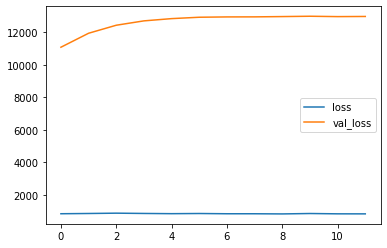

loss =  833.4529418945312 , val_loss =  12977.275390625
73/73 [==============================] - 21s 289ms/step - loss: 833.4529 - mae: 17.6272 - val_loss: 12977.2754 - val_mae: 25.7485 - lr: 2.0000e-05
Epoch 13/30
11/73 [===>..........................] - ETA: 16s - loss: 826.4903 - mae: 17.5984

KeyboardInterrupt: ignored

In [163]:
bbox_model.fit(train_imgs,train_bboxes, epochs=30, verbose=1, batch_size=256, validation_split=0.1,callbacks=callbacks)

## Phase 2 - label classification 

In [164]:
#Env 데이터 파트 
Env_input = Input((144,9)) #<---- shape 
x = Bidirectional(LSTM(128,return_sequences= True))(Env_input) #bidirec
x = Bidirectional(LSTM(128))(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64, activation ='relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation ='relu')(x)
x = BatchNormalization()(x)
Env_output = Dense(10 ,activation='linear')(x)

#iamge 데이터 파트 
image_input = Input((224,224,3))
x = data_augmentation(image_input)
x = conv_layers(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
image_output = Dense(10, activation='linear')(x)

crops_input = Input(4)
x = Dense(64, activation = 'relu')(crops_input)
x = BatchNormalization()(x)
x = Dense(32, activation = 'relu')(x)
x = BatchNormalization()(x)
crops_output = Dense(10, activation = 'linear')(x)

#헤드 결합 
combined_input = concatenate([Env_output,image_output,crops_output])
x= Dense(64, activation = 'relu')(combined_input) #<--- Dense 
x = BatchNormalization()(x)
x= Dense(32, activation = 'relu')(x) #<--- Dense 
x = BatchNormalization()(x)
output = Dense(25,activation = 'softmax')(x)

label_model = Model([Env_input,image_input,crops_input],output)

In [165]:
label_model.compile(optimizer=adam, loss="sparse_categorical_crossentropy",metrics = ['accuracy'])

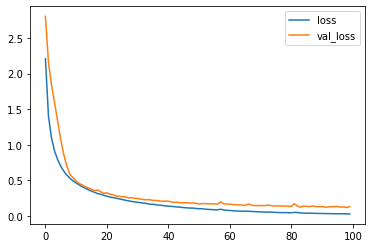

loss =  0.026281043887138367 , val_loss =  0.12906749546527863
73/73 [==============================] - 26s 357ms/step - loss: 0.0263 - accuracy: 0.9982 - val_loss: 0.1291 - val_accuracy: 0.9649 - lr: 2.0000e-05


In [166]:
history = label_model.fit([train_csvs,train_imgs,train_bboxes],train_labels, epochs=100, verbose=1, batch_size=256, validation_split=0.1,callbacks=callbacks)

In [167]:
label_model.save('label_model.h5')
bbox_model.save('bbox_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Submission

## 사전설정

In [9]:
import tensorflow as tf 
from tensorflow import keras

In [11]:
label_model = tf.keras.models.load_model('label_model.h5')
bbox_model = tf.keras.models.load_model('bbox_model.h5')

In [ ]:
!unzip test.zip

In [12]:
test_csv = sorted(glob('test/*/*.csv'))
test_jpg = sorted(glob('test/*/*.jpg'))

In [13]:
i = 10381
pred_csv_1 = np.array(test_csv[:i])
pred_jpg_1 = np.array(test_jpg[:i])

pred_csv_2 = np.array(test_csv[i:i*2])
pred_jpg_2 = np.array(test_jpg[i:i*2])

pred_csv_3 = np.array(test_csv[i*2:i*3])
pred_jpg_3 = np.array(test_jpg[i*2:i*3])

pred_csv_4 = np.array(test_csv[i*3:i*4])
pred_jpg_4 = np.array(test_jpg[i*3:i*4])

pred_csv_5 = np.array(test_csv[i*4:])
pred_jpg_5 = np.array(test_jpg[i*4:])

## 디코더

In [14]:
labels = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
  
        labels.append(label)
        
label_decoding = sorted(np.unique(labels))
label_decoding = {value:key for key,value in zip(label_decoding, range(len(label_decoding)))}

In [15]:
#이미지 파일 로드 
for i in range(1,6):
  exec(f'jpg_source = pred_jpg_{i}')
  exec(f'csv_source = pred_csv_{i}')

  def img_load(path):
      img = cv2.imread(path)
      img = cv2.resize(img, (224, 224))
      return img

  pred_jpgs = [img_load(k) for k in tqdm(jpg_source)]
  pred_jpgs = np.array(pred_jpgs)
  pred_jpgs = efficientnet.preprocess_input(pred_jpgs)

  #csv 파일 로드 

  def csv_load(path):
      temp = pd.read_csv(path)
      temp = np.array(temp[csv_features])
      try:
        temp = temp.astype(float)
      except:
        temp[temp=='-']=0.
        temp = temp.astype(float)
      temp = cv2.resize(temp, dsize = (9,144))
      return temp

  pred_csvs = [csv_load(k) for k in tqdm(csv_source)]
  pred_csvs = np.array(pred_csvs)

  #학습 

  pred_bboxes = bbox_model.predict([pred_jpgs])
  y_1 = label_model.predict([pred_csvs,pred_jpgs,pred_bboxes])
  predicted_label = np.argmax(y_1,axis=1)

  print(i)
  exec(f'a_{i} = predicted_label')

100%|██████████| 10381/10381 [01:13<00:00, 140.81it/s]


1


100%|██████████| 10381/10381 [01:14<00:00, 138.87it/s]


2


100%|██████████| 10381/10381 [01:14<00:00, 139.19it/s]


3


100%|██████████| 10381/10381 [01:13<00:00, 142.17it/s]


4


100%|██████████| 10382/10382 [01:14<00:00, 138.60it/s]


5


In [16]:
print(a_1.shape,a_2.shape,a_3.shape,a_4.shape,a_5.shape)

(10381,) (10381,) (10381,) (10381,) (10382,)


In [17]:
submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
i=10381
submission['label'][:i] =a_1
submission['label'][i:i*2] = a_2
submission['label'][i*2:i*3] = a_3
submission['label'][i*3:i*4] = a_4
submission['label'][i*4:] = a_5

In [19]:
submission['label'] = submission['label'].apply(lambda x:label_decoding[x])

In [21]:
submission.head()

,image,label
0,10000,6_00_0
1,10001,5_b6_1
2,10002,4_00_0
3,10003,3_00_0
4,10004,3_b8_1


In [20]:
submission.to_csv('submission17.csv',index=False)